In [1]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import gc

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib

import pickle
import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [2]:
torch.__version__

'2.1.1+cu121'

In [3]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import train_loop
from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
)

In [4]:
import jupyter_black

jupyter_black.load(line_length=79)

In [5]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")

In [6]:
plt.style.use("../matplotlib_style.txt")

In [7]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers -p openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-01-26 11:48:07CET

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

openTSNE: 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

memory_profiler: 0.61.0
scipy          : 1.11.4
jupyter_black  : 0.3.4
distro         : 1.8.0
numpy          : 1.26.2
torch          : 2.1.1
pandas         : 2.1.3
matplotlib     : 3.8.2

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import

## ICLR

In [8]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 285 ms, sys: 109 ms, total: 394 ms
Wall time: 305 ms


In [9]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [10]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [11]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

In [12]:
# sanity check
print(len(np.unique(labels_iclr)))
labels_iclr

46


array(['unlabeled', 'unlabeled', 'optimization', ..., 'unlabeled',
       'unlabeled', 'federated learning'], dtype='<U34')

# Freeze layers

## Exploration

In [13]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [14]:
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Set the random seed for NumPy
np.random.seed(seed)

# Set the random seed
random.seed(seed)

In [15]:
# initialize
i = 1

# random_state = random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


In [16]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.attn.q.weight: True
encoder.layer.0.attention.attn.q.bias: True
encoder.layer.0.attention.attn.k.weight: True
encoder.layer.0.attention.attn.k.bias: True
encoder.layer.0.attention.attn.v.weight: True
encoder.layer.0.attention.attn.v.bias: True
encoder.layer.0.attention.attn.o.weight: True
encoder.layer.0.attention.attn.o.bias: True
encoder.layer.0.attention.LayerNorm.weight: True
encoder.layer.0.attention.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.attn.q.weight: True
encoder.layer.1.attention.attn.q.bias: True
encoder.layer.1.attention.attn.k.weigh

In [17]:
np.arange(13)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [18]:
# CHECK
# for last_frozen_layer in np.arange(
#     2
# ):  # layers start at 0, so layer 11 in the model output corresponds to 12, and layer 11 of the code model won't be frozen in this case
first_unfrozen_layer = 12
modules = [
    model.embeddings,
    *model.encoder.layer[:first_unfrozen_layer],
]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False
# check that you actually froze the layer
print("Before training -------------------")
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: False
encoder.layer.1.attention

# New freezing experiment

In [13]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [15]:
%%time
for first_unfrozen_layer in np.arange(13):
    print("First unfrozen layer:", first_unfrozen_layer)
    ## set random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    ## initialize model and tokenizer
    i = 1  # MPNet
    model_name = model_names[i]
    print("Model : ", model_names[i])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running on device: {}".format(device))
    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    ## freeze layers
    # last_frozen_layer = 6  # layers start at 0, so layer 11 in the model output corresponds to 12, and layer 11 of the model won't be frozen in this case
    modules = [
        model.embeddings,
        *model.encoder.layer[:first_unfrozen_layer],
    ]
    for module in modules:
        for param in module.parameters():
            param.requires_grad = False

    # check that you actually froze the layer
    print("Before training -------------------")
    for name, param in model.named_parameters():
        print(f"{name}: {param.requires_grad}")

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=1,
        lr=2e-5,
    )

    ## save losses and accuracies
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("freezing_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name_losses = Path(
        "losses_first_unfrozen_layer_" + str(first_unfrozen_layer) + "_v1"
    )
    saving_name_accuracies = Path(
        "knn_accuracies_first_unfrozen_layer_"
        + str(first_unfrozen_layer)
        + "_v1"
    )

    np.save(variables_path / saving_path / saving_name_losses, losses)
    np.save(
        variables_path / saving_path / saving_name_accuracies,
        knn_accuracies,
    )

First unfrozen layer: 0
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: True
encoder.layer.0.attention.attn.q.bias: True
encoder.layer.0.attention.attn.k.weight: True
encoder.layer.0.attention.attn.k.bias: True
encoder.layer.0.attention.attn.v.weight: True
encoder.layer.0.attention.attn.v.bias: True
encoder.layer.0.attention.attn.o.weight: True
encoder.layer.0.attention.attn.o.bias: True
encoder.layer.0.attention.LayerNorm.weight: True
encoder.layer.0.attention.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.attn.q.weight: True
encoder.layer.1.atten

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

First unfrozen layer: 1
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: True
encod

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

First unfrozen layer: 2
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: False
enco

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

First unfrozen layer: 3
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: False
enco

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

First unfrozen layer: 4
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: False
enco

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

First unfrozen layer: 5
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: False
enco

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

First unfrozen layer: 6
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: False
enco

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

First unfrozen layer: 7
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: False
enco

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

First unfrozen layer: 8
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: False
enco

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

First unfrozen layer: 9
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: False
enco

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

First unfrozen layer: 10
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: False
enco

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

First unfrozen layer: 11
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: False
enco

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

First unfrozen layer: 12
Model :  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.attn.q.weight: False
encoder.layer.0.attention.attn.q.bias: False
encoder.layer.0.attention.attn.k.weight: False
encoder.layer.0.attention.attn.k.bias: False
encoder.layer.0.attention.attn.v.weight: False
encoder.layer.0.attention.attn.v.bias: False
encoder.layer.0.attention.attn.o.weight: False
encoder.layer.0.attention.attn.o.bias: False
encoder.layer.0.attention.LayerNorm.weight: False
encoder.layer.0.attention.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1.attention.attn.q.weight: False
enco

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

CPU times: user 1h 42min 8s, sys: 1h 32min 19s, total: 3h 14min 28s
Wall time: 1h 46min 17s


## Plot

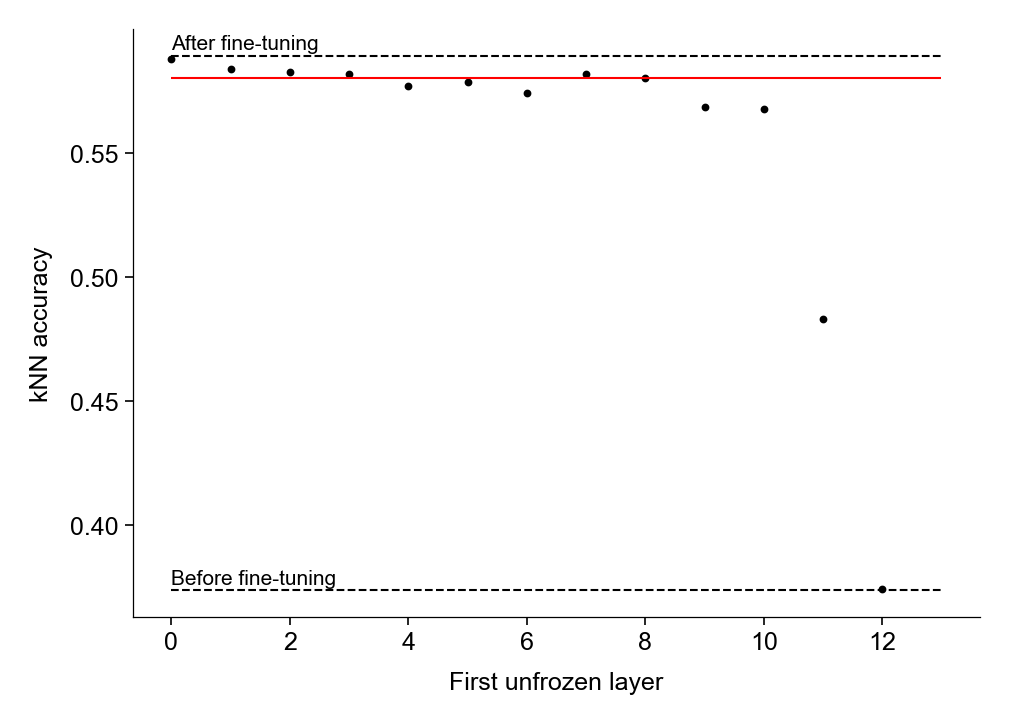

In [32]:
%matplotlib inline


fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"

for first_unfrozen_layer in np.arange(13):
    ## save losses and accuracies
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("freezing_experiment")
    )

    # saving_name_losses = Path(
    #     "losses_first_unfrozen_layer_" + str(first_unfrozen_layer) + "_v1"
    # )
    saving_name_accuracies = Path(
        "knn_accuracies_first_unfrozen_layer_"
        + str(first_unfrozen_layer)
        + "_v1.npy"
    )

    # np.load(variables_path / saving_path / saving_name_losses, losses)
    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies,
    )

    ax.scatter(
        first_unfrozen_layer, knn_accuracies[0, 0], c="k", marker=".", s=3
    )
ax.hlines(0.374, 0, 13, color="k", linestyle="--")
ax.text(
    0,
    0.374 + 0.001,
    f"Before fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)
ax.hlines(0.589, 0, 13, color="k", linestyle="--")
ax.hlines(0.58, 0, 13, color="r", linestyle="-")
ax.text(
    0,
    0.589 + 0.001,
    f"After fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)
ax.set_xlabel("First unfrozen layer")
ax.set_ylabel("kNN accuracy")


fig.savefig(figures_path / "freezing_experiment_mpnet_v1.png")